In [1]:
import os
import pysal as ps 
import pandas as pd 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal.lib
import pysal.explore
import pysal.viz
import pysal.model

C:\Users\jwolf\AppData\Local\conda\conda\envs\pandas\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
os.chdir('C:/Users/jwolf/Documents/MEGA/03_Doutoramento/06_Base de dados/School closure')

In [3]:
path = "C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Administrativos/Municípios/Cont_AAD_CAOP2018/\
Cont_AAD_CAOP2018.shp"
gdf_freguesias_CAOP2018 = gpd.read_file (path)
gdf_freguesias_CAOP2018['code_mun'] = gdf_freguesias_CAOP2018['Dicofre'].str.slice(0,4)

In [4]:
df_correspond_nuts3 = pd.read_csv("CODIGOS_MUNICIPIOS_NUTS3.csv",engine='python', header = 0,\
                                  sep = ";",dtype= {'Cod_mun': str}, decimal=",")
df_correspond_nuts3.dropna(inplace = True)

In [5]:
# pd.merge(gdf_freguesias_CAOP2018, df_correspond_nuts3, how = left,  left_on = "code_mun")
gdf_freguesias_CAOP2018= pd.merge(gdf_freguesias_CAOP2018, df_correspond_nuts3, how='left', left_on = "code_mun",right_on= "Cod_mun")
gdf_freguesias_CAOP2018.drop(['Cod_mun'], axis=1, inplace = True)

In [6]:
#3763 código epsg etrs89 e Portugal TM06
#WGS84 = epsg 4326

gdf_freguesias_CAOP2018 = gdf_freguesias_CAOP2018.to_crs(epsg=3763)

In [7]:
gdf_municipios_CAOP2018 = gdf_freguesias_CAOP2018.dissolve(by='code_mun')
gdf_municipios_CAOP2018.drop(['Dicofre','Freguesia', 'Des_Simpli', 'TAA'], axis = 1, inplace = True)

In [8]:
df_schools = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/Schools.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'Code': str}, decimal=",")
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_schools, how='left', left_on=['code_mun'],\
                                   right_on = ['Code'])

In [9]:
l = []
l = list(gdf_municipios_CAOP2018.columns[:9]) + \
["Escolas_" + s  for s in gdf_municipios_CAOP2018.columns[9:24].str.slice(0,4)] +\
list(gdf_municipios_CAOP2018.columns[24:])

gdf_municipios_CAOP2018.columns = l

In [ ]:
#gdf_municipios_CAOP2018.columns.get_loc('TX_99_17')

In [11]:
df_TFR = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/ISF_2017_pivot.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'Code': str}, decimal=",")
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_TFR, how='left', left_on=['Code'],\
                                   right_on = ['code'])

In [12]:
l = []
l = list(gdf_municipios_CAOP2018.columns[0:26]) + ["TFR_" + s  for s in gdf_municipios_CAOP2018.columns[26:53]]
gdf_municipios_CAOP2018.columns = l


In [13]:
df_Migration = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/MIGRANTS_pivot.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'code': str}, decimal=",")

In [14]:
df_Migration.head(3)
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_Migration, how='left', left_on=['Code'],\
                                   right_on = ['code'])

In [15]:
l = []
l = list(gdf_municipios_CAOP2018.columns[:54]) + ["MIGR_" + s  for s in gdf_municipios_CAOP2018.columns[54:]]
gdf_municipios_CAOP2018.columns = l


In [16]:
def Local_moran_I (l, matrizes): 
    a = {}
    for i in l:
        key = str(i)
        value = pysal.explore.esda.Moran_Local\
        (gdf_municipios_CAOP2018[i], matrizes[1], transformation='r', permutations=999)
        a[key] = (matrizes[0],value)
    return(a)


In [17]:
n_vizinhos = 3
distancia=30000
matrizes = []
matrizes = [("Queen "+str(n_vizinhos)+" neighbours"),\
            pysal.lib.weights.KNN.from_dataframe(gdf_municipios_CAOP2018, k= n_vizinhos)]

#[("Distance "+str(distancia//1000)+'km'),\
#pysal.lib.weights.DistanceBand.from_dataframe(gdf_municipios_CAOP2018, \
#p = 2, alpha=-3, threshold= distancia)]
    

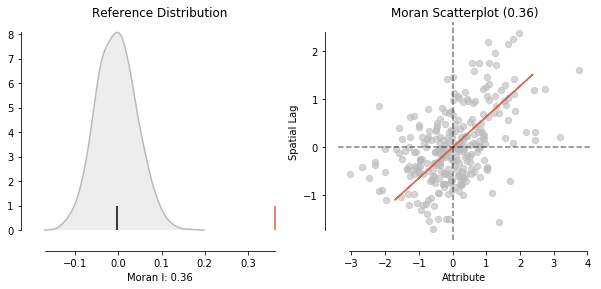

In [18]:
from pysal.explore.esda.moran import Moran
from pysal.viz.splot.esda import plot_moran
l = ['MIGR_1999','MIGR_2017',
    'TFR_1999','TFR_2017']

# fig, axs = plt.subplots(1, len(l))


# fig, ax = moran_scatterplot(moran, aspect_equal=True)
# plt.show()

moran_I = pysal.explore.esda.Moran(gdf_municipios_CAOP2018['TFR_2017'], matrizes[1], transformation='r', permutations=999)
# print("p value =", moran_I.p_norm, "Moran I = ", moran_I.I,"expected value under normality assumption", moran_I.EI) 
plot_moran(moran_I)
plt.show()

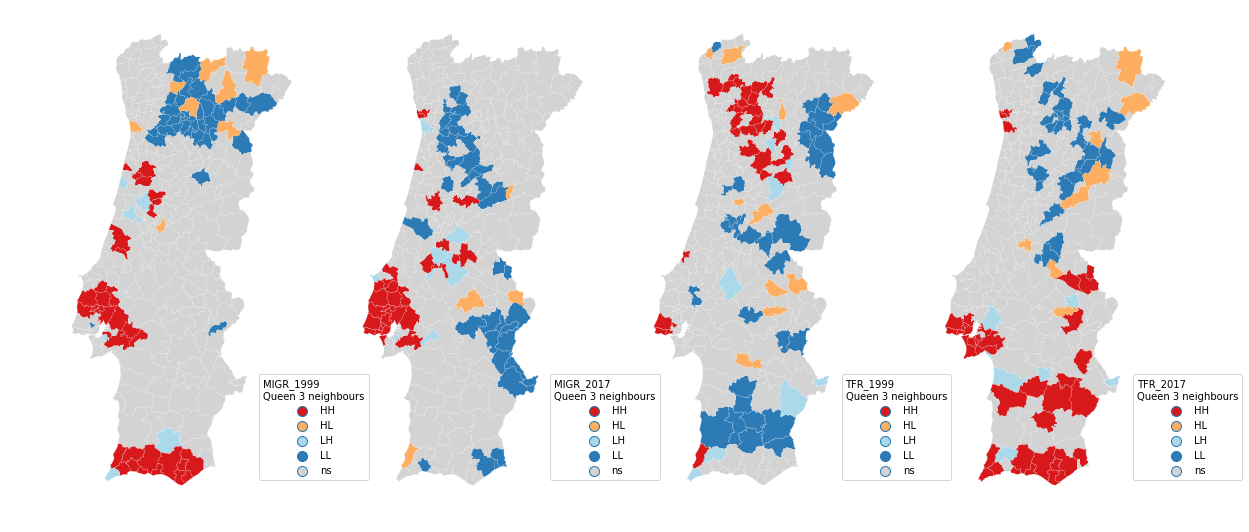

In [33]:
from pysal.viz.splot.esda import lisa_cluster
gdf_municipios_CAOP2018_2 = gdf_municipios_CAOP2018.copy()


l = ['MIGR_1999','MIGR_2017',
    'TFR_1999','TFR_2017']
    #'TX_99_17', 'TFR_1997','TFR_2017'
a = Local_moran_I(l, matrizes)
             
fig, axs = plt.subplots(1,len(a),figsize = (20,20))
i=0 
j=0


for x, value in dict.items(a):
    legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
    'title': x + '\n'+ value[0]}
    lisa_cluster(value[1], gdf_municipios_CAOP2018_2, p=0.1, ax = axs [i], \
    legend_kwds= legenda)
    i+=1
plt.savefig('IND_Moran.png', dpi=600,  bbox_inches="tight")

In [20]:
#fig, ax = plt.subplots(1, figsize=(10, 6))
# ax.axis('off')
#gdf_municipios_CAOP2018.plot(ax = ax,column='2017')
# gdf_freguesias_CAOP2018.plot(ax = ax , linewidth=0, column = 0)

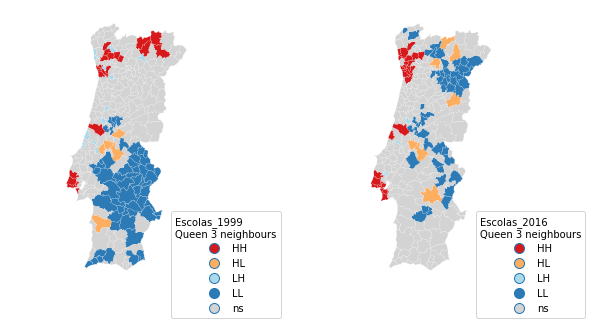

In [21]:
l = ['Escolas_1999', 'Escolas_2016']
a = Local_moran_I(l, matrizes)
             
fig, axs = plt.subplots(1,len(a),figsize = (10,5))
i=0 
j=0

for x, value in dict.items(a):
    legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
    'title': x + '\n'+ value[0]}
    lisa_cluster(value[1], gdf_municipios_CAOP2018_2, p=0.1, ax = axs [i], \
    legend_kwds= legenda)
    i+=1

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216e5e1bb00>)

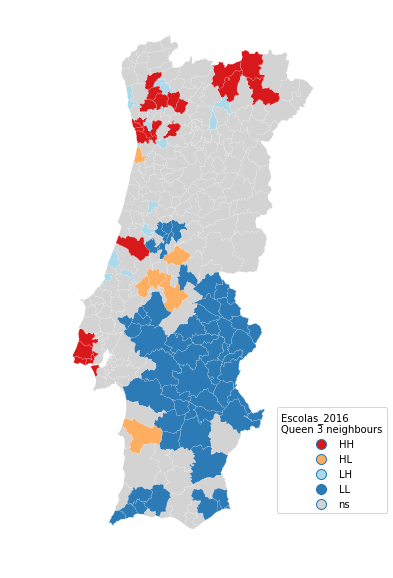

In [22]:
moran = pysal.explore.esda.Moran_Local\
(gdf_municipios_CAOP2018['Escolas_1999'], matrizes[1], transformation='r', permutations=999)

#fig, ax = plt.plot(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(20, 10))
colors_list = ['#d7191c', '#fdae61', '#abd9e9', '#2c7bb6', 'black']
legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
'title': x + '\n'+ value[0]}
lisa_cluster(moran, gdf_municipios_CAOP2018.copy(), p=0.1,legend_kwds= legenda, ax = ax)


# colors.ListedColormap(colors5)
# moran.q
# PySAL Scheme: HH=1, LH=2, LL=3, HL=4

In [24]:
df_Schools_FDM = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/Primary_Schools_FDM_2.csv",\
                         engine='python', sep = ";",dtype= {'Code': str}, decimal=",", header=0)
#gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_TFR, how='left', left_on=['Code'],\
#                                   right_on = ['code'])

In [25]:
l = []
l = ["TFR_FDM" + s  for s in df_Schools_FDM.columns[0:]]
df_Schools_FDM.columns = l 


In [29]:
df_Schools_FDM.head(3)

,TFR_FDMCode,TFR_FDM1999,TFR_FDM2000,TFR_FDM2001,TFR_FDM2002,TFR_FDM2003,TFR_FDM2004,TFR_FDM2005,TFR_FDM2006,TFR_FDM2007,TFR_FDM2008,TFR_FDM2009,TFR_FDM2010,TFR_FDM2011,TFR_FDM2012,TFR_FDM2013,TFR_FDM2014,TFR_FDM2015
0,0101,0.450269,0.455058,0.436902,0.442898,0.451015,0.461850,0.4762166,0.3729169,0.1986234,0.2234514,0.21381,0.249445,0.2993338,0.3741674,0.4485693,0.4222729,0.207638
1,0102,0.448421,0.375180,0.400192,0.401651,0.404574,0.409398,0.4167259,0.3737414,0.3699102,0.2659264,0.303916,0.3545685,0.305382,0.000000477,0.000000715,0.000000954,0.000002
2,0103,0.555039,0.589729,0.629044,0.650933,0.677335,0.709435,0.7488492,0.6877587,0.4638536,0.2110505,0.2412007,0.2271273,0.2140045,0.2675056,0.3566742,-0.000000954,-0.000002


In [27]:
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_Schools_FDM, how='left', left_on=['Code'],\
                                  right_on = ['TFR_FDMCode'])

In [28]:
gdf_municipios_CAOP2018.head(2)

,geometry,Concelho,Distrito,AREA_EA_Ha,AREA_T_Ha,NUTS3_2016,NUTS_nome,Code,Name,Escolas_1999,...,TFR_FDM2006,TFR_FDM2007,TFR_FDM2008,TFR_FDM2009,TFR_FDM2010,TFR_FDM2011,TFR_FDM2012,TFR_FDM2013,TFR_FDM2014,TFR_FDM2015
0,POLYGON ((-14839.47989999963 103073.8716999997...,ÁGUEDA,AVEIRO,1019.01,1019.01,16D,Região de Aveiro,0101,Águeda,46,...,0.3729169,0.1986234,0.2234514,0.21381,0.249445,0.2993338,0.3741674,0.4485693,0.4222729,0.207638
1,POLYGON ((-29041.31800000001 108973.6844999988...,ALBERGARIA-A-VELHA,AVEIRO,1535.86,1535.86,16D,Região de Aveiro,0102,Albergaria-a-Velha,33,...,0.3737414,0.3699102,0.2659264,0.303916,0.3545685,0.305382,0.000000477,0.000000715,0.000000954,0.000002


(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216e97c6470>)

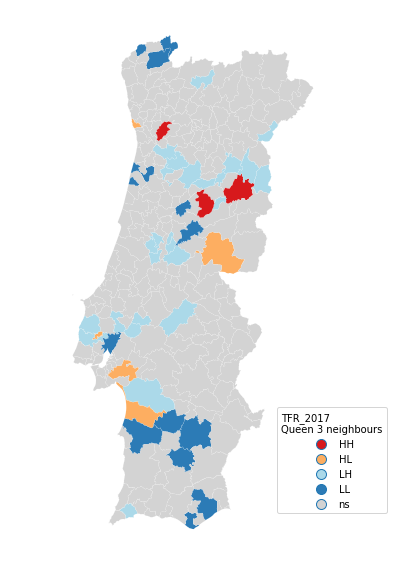

In [35]:
moran = pysal.explore.esda.Moran_Local\
(gdf_municipios_CAOP2018['TFR_FDM2015'], matrizes[1], transformation='r', permutations=999)

#fig, ax = plt.plot(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(20, 10))
# colors_list = ['#d7191c', '#fdae61', '#abd9e9', '#2c7bb6', 'black']
legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
'title': x + '\n'+ value[0]}
lisa_cluster(moran, gdf_municipios_CAOP2018.copy(), p=0.1,legend_kwds= legenda, ax = ax)